<a href="https://colab.research.google.com/github/yesyell/CXR-Few-shot-Classification/blob/main/notebook/CLIP_Full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install transformers

In [ ]:
import os
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
import clip
#Constructs a CLIP processor which wraps a CLIP image processor and a CLIP tokenizer into a single processor.
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import re
import time
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from transformers import AdamW
import math

In [ ]:
print("Torch version:", torch.__version__)

Torch version: 2.0.1+cu118


In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CLIP model with RN50 as the image encoder
model, preprocess = clip.load("RN50", device)

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
model

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [ ]:
# Hyperparameters
batch_size = 10
learning_rate = 5e-6
num_epochs = 10
temperature = 0.05

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, sample_limit=None):
        self.data_frame = pd.read_csv(csv_file, dtype={'image_path': str, 'text_path': str})
        self.root_dir = root_dir
        self.transform = transform
        self.images = [] # List to store images
        self.texts = [] # List to store texts

         # If a sample_limit is provided, limit the number of samples
        if sample_limit is not None:
            self.data_frame = self.data_frame.head(sample_limit)

        # Load and preprocess images and texts, and store them in lists
        for idx in range(len(self.data_frame)):
            img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1]) # 1 - for images (2nd column)
            text_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 2]) # 1 - for texts (3rd column)

            # Open and preprocess the image
            image = Image.open(img_path).convert("RGB")
            if self.transform:
              image = self.transform(image)

            # Read the text file
            with open(text_path, 'r') as text_file:
                text = text_file.read()

            self.images.append(image)
            self.texts.append(text)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image = self.images[idx]
        text = self.texts[idx]

        return image, text

# Paths to train and validation CSV files
train_csv_file = '/content/drive/MyDrive/dataset/physionet.org/train_data_p10.csv'
val_csv_file = '/content/drive/MyDrive/dataset/physionet.org/val_data_p10.csv'

# Root directory where the images and text files are located
root_dir = '/content/drive/MyDrive/dataset/physionet.org' # Modify this to match the new path prefix

# Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

# Specify the number of samples you want to use for training and validation
train_sample_limit = 80  # Number of samples for training
val_sample_limit = 20    # Number of samples for validation

# Create separate datasets for train and validation
train_dataset = CustomDataset(csv_file=train_csv_file, root_dir=root_dir, transform=transform, sample_limit=train_sample_limit)
val_dataset = CustomDataset(csv_file=val_csv_file, root_dir=root_dir, transform=transform, sample_limit=val_sample_limit)

# Define train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Now you have separate train_dataset and val_dataset instances for training and validation.

In [ ]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))

80
20


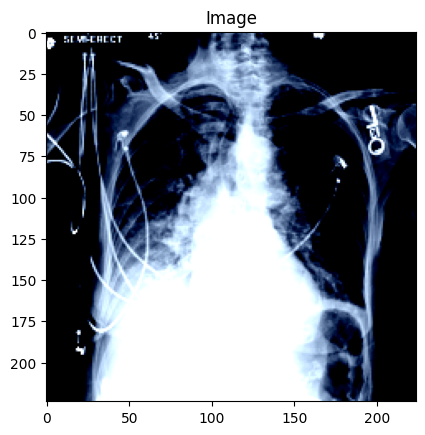

Text:
                                 FINAL REPORT
 HISTORY:  Sepsis with mitral regurgitation and possible worsening pulmonary
 edema.
 
 FINDINGS:  In comparison with the study of ___, the bibasilar opacification
 has somewhat decreased bilaterally.  The time course suggests that much of
 this appearance may have reflected improved pulmonary edema.  Nevertheless,
 there is continued engorgement of pulmonary vessels more prominent on the
 right, consistent with some persistent elevation of pulmonary venous pressure.
 Hazy opacification on the right suggests pleural fluid.
 
 In the appropriate clinical setting, supervening pneumonia would certainly
 have to be considered.  Loss of the medial aspect of the left hemidiaphragm
 suggests some volume loss in the retrocardiac portion of the lower lobe.



In [ ]:
# the tuple contains the first image (represented as a tensor) and the corresponding text (a string)
sample = train_dataset[77]

sample_image = sample[0]
sample_text = sample[1]

# Print the image (you may need to adjust this based on your image format)
plt.imshow(sample_image.permute(1,2,0))  # Assuming your image is in CHW format, so permute to HWC
plt.title('Image')
plt.show()

# Print the corresponding text
print('Text:')
print(sample_text)

In [ ]:
def extract_findings(text):
    # 정규 표현식을 사용하여 "FINDINGS:", "IMPRESSION:" 또는 "FINDINGS/IMPRESSIONS:" 이후의 텍스트 추출
    findings_match = re.search(r'(?:FINDINGS|IMPRESSIONS?):(.*?)(?:IMPRESSION:|$)', text, re.DOTALL | re.IGNORECASE)
    if findings_match:
        findings_text = findings_match.group(1).strip()
    else:
        # 해당 패턴이 없는 경우 원본 텍스트 그대로 반환
        findings_text = text.strip()
    return findings_text

findings_texts = extract_findings(sample_text)

# Initialize the CLIP processor (Hugging Face Transformers library)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Define the maximum context length (77 tokens)
max_context_length = 77

# Tokenize the "FINDINGS" text, ensuring it fits within the context length
tokenized_findings = processor(text=findings_texts, return_tensors="pt", max_length=max_context_length, truncation=True, padding="max_length")

print(findings_texts)
print(tokenized_findings)
print(type(tokenized_findings))

In comparison with the study of ___, the bibasilar opacification
 has somewhat decreased bilaterally.  The time course suggests that much of
 this appearance may have reflected improved pulmonary edema.  Nevertheless,
 there is continued engorgement of pulmonary vessels more prominent on the
 right, consistent with some persistent elevation of pulmonary venous pressure.
 Hazy opacification on the right suggests pleural fluid.
 
 In the appropriate clinical setting, supervening pneumonia would certainly
 have to be considered.  Loss of the medial aspect of the left hemidiaphragm
 suggests some volume loss in the retrocardiac portion of the lower lobe.
{'input_ids': tensor([[49406,   530, 14186,   593,   518,  3123,   539,  2355, 31417,   518,
           717, 19225,   625,   676,  4359,  4523,   791, 17864, 33913,  3092,
         18597,   769,   269,   518,   788,  2613, 13333,   682,  1238,   539,
           589,  7238,  1270,   720, 28732,  9446, 39132, 29632,  1226,   269,
         48

In [ ]:
# Initialize the optimizer with the CLIP model parameters and learning rate
# bias 및 다른 파라미터에는 weight decay 적용
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.1)

# Define a linear warm-up function for the learning rate
def linear_warmup(current_step, warmup_steps):
    return min(1.0, current_step / warmup_steps)

# Create a learning rate scheduler with cosine annealing and linear warm-up
warmup_steps = len(train_loader)  # 1 epoch linear warm-up
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: linear_warmup(step, warmup_steps) * 0.5 * (1 + math.cos(math.pi * step / (num_epochs * len(train_loader)))),)

# Define the CrossEntropyLoss for image and text losses
loss_image = nn.CrossEntropyLoss()
loss_text = nn.CrossEntropyLoss()

start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    # Use tqdm to display a progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for batch_images, batch_texts in train_loader:
            batch_images = batch_images.to(device)

            # Extract the section using regex for each text in the batch
            findings_texts = []
            for text in batch_texts:
              findings_text = extract_findings(text)
              findings_texts.append(findings_text)

            # Tokenize the text for the entire batch
            tokenized_findings = processor(text=findings_texts, return_tensors="pt", max_length=max_context_length, truncation=True, padding="max_length")
            token_ids_findings = tokenized_findings['input_ids']
            token_ids_findings = token_ids_findings.to(device)

            logits_per_image, logits_per_text = model(batch_images, token_ids_findings)
            ground_truth = torch.arange(len(batch_images), dtype=torch.long, device=device)

            loss = (loss_image(logits_per_image, ground_truth) + loss_text(logits_per_text, ground_truth)) / 2.0

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.update(1)  # Update the progress bar

        # Update the learning rate at the end of each epoch
        scheduler.step()

    end_time = time.time()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_total_loss = 0.0
    with torch.no_grad():
        for batch_images, batch_texts in val_loader:
            # ... (same code as in the training loop)
            batch_images = batch_images.to(device)

            # Extract the section using regex for each text in the batch
            findings_texts = []
            for text in batch_texts:
              findings_text = extract_findings(text)
              findings_texts.append(findings_text)

            # Tokenize the "FINDINGS" text for the entire batch
            tokenized_findings = processor(text=findings_texts, return_tensors="pt", max_length=max_context_length, truncation=True, padding="max_length")
            token_ids_findings = tokenized_findings['input_ids']
            token_ids_findings = token_ids_findings.to(device)

            logits_per_image, logits_per_texㅇt = model(batch_images, token_ids_findings)
            ground_truth = torch.arange(len(batch_images), dtype=torch.long, device=device)

            loss = (loss_image(logits_per_image, ground_truth) + loss_text(logits_per_text, ground_truth)) / 2.0

            val_total_loss += loss.item()

    # Calculate and print the average loss for the epoch
    average_loss = total_loss / len(train_loader)
    val_average_loss = val_total_loss / len(val_loader)
    epoch_time = end_time - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {average_loss:.4f} Validation Loss: {val_average_loss:.4f} Time: {epoch_time:.2f} seconds")

    start_time = time.time()

# Training is complete
print("Training finished.")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [1/10] Train Loss: 5.8242 Validation Loss: 3.8192 Time: 114.59 seconds


Epoch 2/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [2/10] Train Loss: 5.2467 Validation Loss: 4.6179 Time: 110.70 seconds


Epoch 3/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [3/10] Train Loss: 3.8170 Validation Loss: 3.1726 Time: 100.98 seconds


Epoch 4/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [4/10] Train Loss: 2.7937 Validation Loss: 3.1269 Time: 97.65 seconds


Epoch 5/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [5/10] Train Loss: 2.2418 Validation Loss: 3.1058 Time: 96.21 seconds


Epoch 6/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [6/10] Train Loss: 1.7256 Validation Loss: 3.2532 Time: 96.01 seconds


Epoch 7/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [7/10] Train Loss: 1.4939 Validation Loss: 3.0707 Time: 97.77 seconds


Epoch 8/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [8/10] Train Loss: 1.1386 Validation Loss: 2.3529 Time: 97.05 seconds


Epoch 9/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [9/10] Train Loss: 0.7520 Validation Loss: 2.3048 Time: 104.12 seconds


Epoch 10/10:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [10/10] Train Loss: 0.5027 Validation Loss: 2.3743 Time: 95.29 seconds


In [ ]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"/content/drive/MyDrive/CLIP_model.pt") #just change to your preferred folder/filename